In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#from Methods import EstimationMethods
import Methods_new as method
from Gen_data import SimulationStudy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def get_split(simulation: pd.DataFrame) -> tuple[pd.DataFrame]:
    
    train_df, test_df = train_test_split(simulation, test_size=0.5, random_state=42)

    # Extract features and target variables for training
    X_train = train_df[[col for col in simulation.columns if col.startswith('X')]]
    T_train = train_df['T']
    Y_train = train_df['y']

    # Extract features and true CATE for testing
    X_test = test_df[[col for col in simulation.columns if col.startswith('X')]]
    T_test = test_df['T']
    y_test = test_df['y']

    true_cate_train = train_df[['CATE', 'T']]
    true_cate_test = test_df[['CATE', 'T']]

    return train_df, test_df, X_train, Y_train, T_train, X_test, T_test, y_test, true_cate_train, true_cate_test

In [6]:
n_list = [500, 1000, 2000, 3000, 4000]
def mse_analysis(n_list: list,  ols: bool = False, t_learner: bool = False, cf_dml: bool = False, x_learner: bool = False, grf: bool = False) -> pd.DataFrame:
    dict_test = {}
    dict_train = {}

    for n in tqdm(n_list):
            
        li_train = []
        li_test = []

        for i in range(4):

            sim: SimulationStudy = SimulationStudy(p=20, mean_correlation=0.1, cor_variance=0.2, n=n, no_feat_cate=4, non_linear='linear')
            simulation = sim.create_dataset()
            train_df, test_df, X_train, Y_train, T_train, X_test, T_test, Y_test, true_cate_train, true_cate_test = get_split(simulation)
            
            
            if ols is True:
                estimated_cate_train, estimated_cate_test, MSE_train, MSE_test = method.ols_estimator(X_train, X_test, Y_train, T_train, T_test, true_cate_train, true_cate_test)
            elif t_learner is True:
                estimated_cate_train, estimated_cate_test, MSE_test, MSE_train = method.TLearner_estimator(Y_train, T_train, X_train, X_test, true_cate_train, true_cate_test)
            elif cf_dml is True:
                estimated_cate_train, estimated_cate_test, MSE_test, MSE_train = method.CF_DML(Y_train, T_train, X_train, X_test, true_cate_train, true_cate_test)
            elif x_learner is True:
                estimated_cate_train, estimated_cate_test, MSE_test, MSE_train = method.XLearner_estimator(Y_train, T_train, X_train, X_test, true_cate_train, true_cate_test)
            elif grf is True:
                estimated_cate_train, estimated_cate_test, MSE_test, MSE_train = method.GRF_estimator(Y_train, T_train, X_train, X_test, true_cate_train, true_cate_test)
            else:
                print('Choose either ols, t_learner, cf_dml, x_learner or grf')
                
            li_train.append(MSE_train)
            li_test.append(MSE_test)

        mse_train_mean = np.mean(np.array(li_train))
        mse_test_mean = np.mean(np.array(li_test))
            

        key = f'{n}'
        dict_test[key] = mse_test_mean
        dict_train[key] = mse_train_mean

        mse_df = pd.DataFrame()
        mse_df['n'] = dict_test.keys()
        mse_df['MSE Test'] = dict_test.values()
        mse_df['MSE Train'] = dict_train.values()


    return mse_df


In [7]:
#mse_ols = mse_analysis(ols=True)
mse_t = mse_analysis(n_list, t_learner=True)
#mse_cf_dml = mse_analysis(cf_dml=True)
#mse_x = mse_analysis(x_learner=True)
#mse_grf = mse_analysis(grf=True)


100%|██████████| 5/5 [13:17<00:00, 159.50s/it]


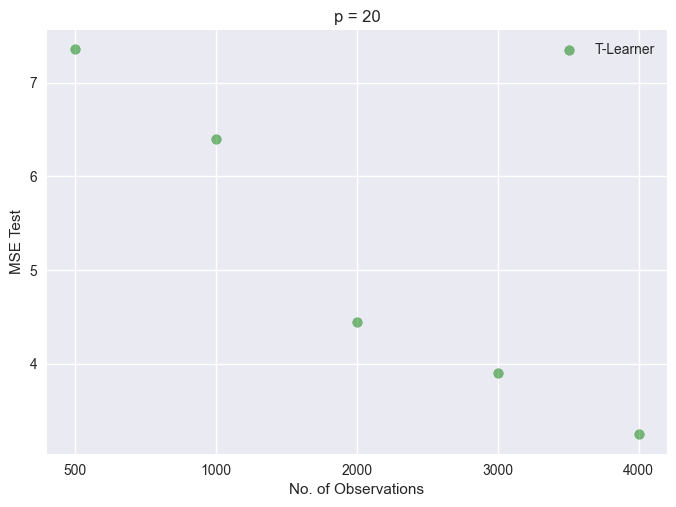

In [9]:
# Use the n values to set the ticks
# Create the scatter plot
plt.style.use('seaborn-v0_8')
#plt.scatter(mse_ols['n'], mse_ols['MSE Test'], alpha=0.5, color='red', label='OLS')
plt.scatter(mse_t['n'], mse_t['MSE Test'], alpha=0.5, color='green', label='T-Learner')
#plt.scatter(mse_cf_dml['n'], mse_cf_dml['MSE Test'], alpha=0.5, color='blue', label='Causal Forest DML')
#plt.scatter(mse_x['n'], mse_x['MSE Test'], alpha=0.5, color='purple', label='X-Learner')
#plt.scatter(mse_grf['n'], mse_grf['MSE Test'], alpha=0.5, color='grey', label='Generalized Random Forest')


# Set the x-ticks and y-ticks
#plt.xticks([])
# Set labels and legend
plt.xlabel('No. of Observations')
plt.ylabel('MSE Test')
plt.title('p = 20')
plt.legend()

# Show the plot
plt.show()